In [1]:
#import packages
import os, csv, time
import pandas as pd
import numpy as np

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import autocast

import torchvision.transforms as transforms

from timm.models import create_model

from sklearn.metrics import f1_score
from livelossplot import PlotLosses

from tqdm import tqdm

/users/snranepuradewage/.lico_env/jupyter/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_DIR = os.path.join("/users/snranepuradewage/roco_multimodal/baseline/models_concept/")
filenameCSV=MODEL_DIR+"HyperparameterTuning_EfficientNetB0.csv"
DATA_DIR="/users/snranepuradewage/roco-dataset-master/data-master"
data_train=DATA_DIR+"/train/"
data_valid=DATA_DIR+"/valid/"

In [3]:
#load dataset with IDs
df_train=pd.read_csv(DATA_DIR+"/train_concepts.csv",sep=",")
df_valid=pd.read_csv(DATA_DIR+"/valid_concepts.csv",sep=",")

In [4]:
df_train

,ID,CUIs
0,ROCOv2_2023_train_000001,C0040405
1,ROCOv2_2023_train_000002,C0041618
2,ROCOv2_2023_train_000003,C0040405;C0817096;C0205271
3,ROCOv2_2023_train_000004,C0002978;C0036033;C1266909;C0225317
4,ROCOv2_2023_train_000005,C0040405;C0817096;C0497156
...,...,...
59953,ROCOv2_2023_train_060159,C0040405;C0005682
59954,ROCOv2_2023_train_060160,C1306645;C0000726;C1999039;C0022646;C0006736
59955,ROCOv2_2023_train_060161,C0002978;C1510412;C0226333
59956,ROCOv2_2023_train_060162,C0002978;C1510412


In [5]:
df_valid

,ID,CUIs
0,ROCOv2_2023_valid_000001,C1306645;C0817096;C1996865;C0442800;C0018787;C...
1,ROCOv2_2023_valid_000002,C1306645;C0030797;C0016169;C0227668;C0302148
2,ROCOv2_2023_valid_000003,C1306645;C0006141;C0006826;C0332482;C0206692;C...
3,ROCOv2_2023_valid_000004,C0040405;C1306460
4,ROCOv2_2023_valid_000005,C0040405;C0035359;C0027651
...,...,...
9899,ROCOv2_2023_valid_009944,C0041618
9900,ROCOv2_2023_valid_009945,C0040405;C0003489;C0042459
9901,ROCOv2_2023_valid_009946,C0040405;C2733397;C0456944;C0180499;C0225844
9902,ROCOv2_2023_valid_009947,C0041618


In [6]:
df_train["image_path"]=data_train+df_train.ID+".jpg"
df_valid["image_path"]=data_valid+df_valid.ID+".jpg"

In [7]:
cuis_list=[]
for (i,row) in df_train.iterrows():
    for cui in row["CUIs"].split(";"):
        if not cui in cuis_list:
            cuis_list.append(cui)

In [8]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [9]:
NUM_CLASSES=len(cuis_list)

In [10]:
print("Total unique CUIs:", len(cuis_list))

Total unique CUIs: 1947


In [10]:
class ROCOv2Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform # Image augmentation pipeline

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        obj = self.data.iloc[index] # get instance
        label = obj.CUIs # get label
        label_enc=torch.zeros((NUM_CLASSES))
        for cui in label.split(";"):
            label_enc[cuis_list.index(cui)]=1
        img = Image.open(obj.image_path).convert("RGB") # load image
        img = self.transform(img)

        return (img, label_enc)


In [11]:
def get_val_preprocessing(img_size):
    return transforms.Compose([
                transforms.Resize(int(img_size * 1.25)), # Expand IMAGE_SIZE before center crop
                transforms.CenterCrop(int(img_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

class IdentityTransform:
    def __call__(self, x):
        return x


def get_train_augmentation_preprocessing(img_size, rand_aug=False):
    return transforms.Compose([
                transforms.Resize(int(img_size * 1.25)), # Expand IMAGE_SIZE before random crop
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomCrop((img_size, img_size)), # Random Crop to IMAGE_SIZE
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

In [12]:
# shuffle
train_data = df_train.sample(frac=1, random_state=1).reset_index(drop=True)
valid_data = df_valid.sample(frac=1, random_state=1).reset_index(drop=True)

In [13]:
imgsize_train=224
imgsize_val=224

In [14]:
train_aug_preprocessing = get_train_augmentation_preprocessing(imgsize_train, True)
val_preprocessing = get_val_preprocessing(imgsize_val)

In [15]:
train_dataset= ROCOv2Dataset(df_train, transform=train_aug_preprocessing)
valid_dataset = ROCOv2Dataset(df_valid, transform=val_preprocessing)


In [16]:
BATCH_SIZE=256

In [17]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=9, drop_last=True, pin_memory=True)
valid_loader = DataLoader(dataset=valid_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=9, drop_last=False, pin_memory=True)

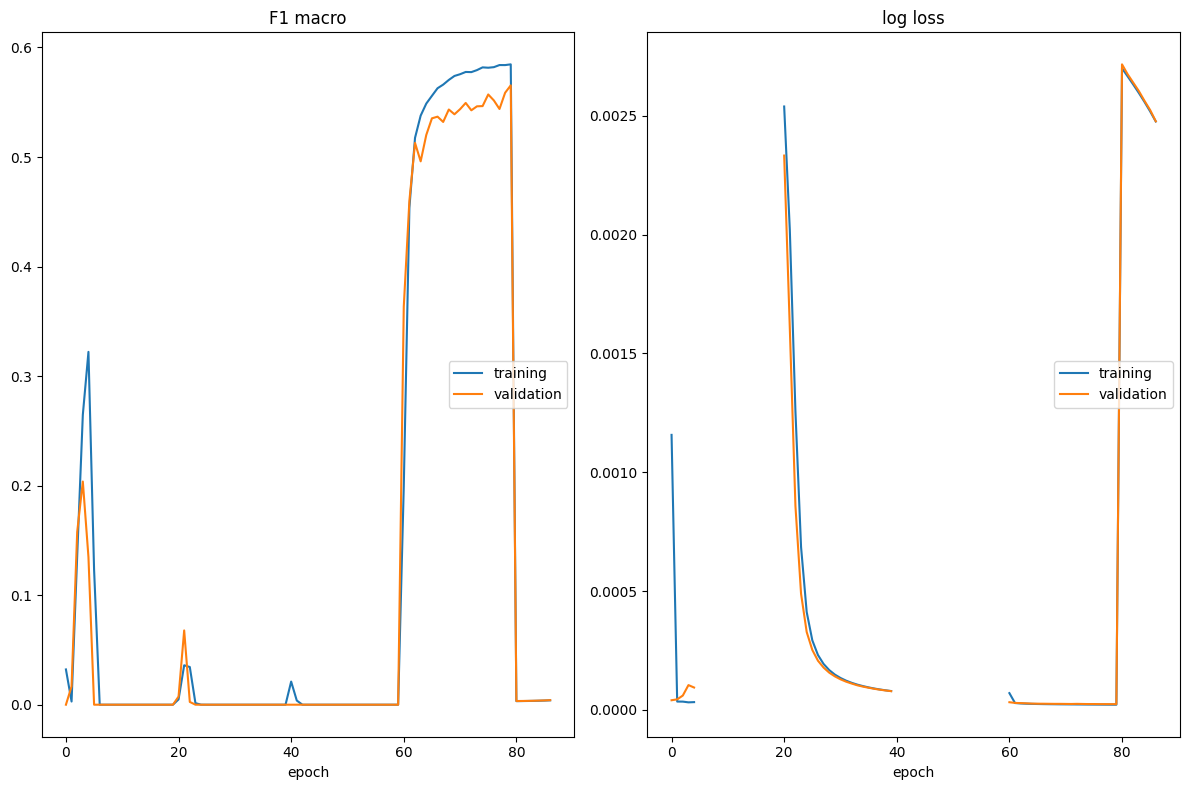

F1 macro
	training         	 (min:    0.000, max:    0.585, cur:    0.004)
	validation       	 (min:    0.000, max:    0.565, cur:    0.004)
log loss
	training         	 (min:    0.000, max:    0.003, cur:    0.002)
	validation       	 (min:    0.000, max:    0.003, cur:    0.002)
--- 124.21137595176697 seconds ---


Epoch [8/20]:  97%|█████████▋| 228/234 [01:20<00:02,  2.54it/s]

In [ ]:
liveloss = PlotLosses()
m = nn.Sigmoid()
for lr in [1e-1,1e-2,1e-3,1e-4,1e-5]:
    for opt in ["adam","sgd","rmsprop"]:
        use_amp = True
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        batchsize_factor=1
        val_interval = 1
        epoch_loss_values = []
        max_epochs = 20
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model=create_model('efficientnet_b0', pretrained=True, num_classes=NUM_CLASSES, drop_path_rate=0.2)
        loss_function = nn.MultiLabelSoftMarginLoss()
        if opt == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif opt== "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        else:
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        model = model.to(device)
        for epoch in range(max_epochs):
            start_time = time.time()
            model.train()
            logs = {}
            epoch_loss = 0
            epoch_loss_val = 0
            step = 0
            labels_sum = np.empty([0,NUM_CLASSES])
            pred_sum = np.empty([0,NUM_CLASSES])
            labels_sum_val = np.empty([0,NUM_CLASSES])
            pred_sum_val = np.empty([0,NUM_CLASSES])
            
            for batch_idx,(inputs, labels) in enumerate(
            tqdm(train_loader, desc=f"Epoch [{epoch+1}/{max_epochs}]", leave=False)):
                step += 1
                inputs = inputs.cuda()
                labels = labels.cuda()
                with autocast(device_type = 'cuda', enabled = True): 
                    outputs = model(inputs)
                    loss = loss_function(outputs,labels)
                    loss = loss / batchsize_factor
                    scaler.scale(loss).backward()
                    output_sig = m(outputs)
                    output_sig_class = (output_sig>=0.5).long()
                if (step+1) % batchsize_factor == 0:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none = True)
                epoch_loss += (loss.item() * batchsize_factor)
                epoch_len = len(train_dataset) // train_loader.batch_size
                labels_sum = np.append(labels_sum, labels.detach().cpu().numpy(), axis = 0)

                pred_sum = np.append(pred_sum, output_sig_class.detach().cpu().numpy(), axis = 0)

            logs['log loss'] = epoch_loss / len(train_dataset)
            logs['F1 macro'] = f1_score(labels_sum.T, pred_sum.T, average='macro')
            epoch_loss_values.append(epoch_loss)
            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    num_correct = 0.0
                    metric_count = 0
                    for batch_idx, (inputs, labels) in enumerate(valid_loader):
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                        with autocast(device_type = 'cuda', enabled = True):  
                            outputs = model(inputs)
                            loss = loss_function(outputs, labels)
                            loss = loss / batchsize_factor
                            output_sig = m(outputs)
                            output_sig_class = (output_sig >= 0.5).long()
                        labels_sum_val = np.append(labels_sum_val, labels.detach().cpu().numpy(), axis = 0)
                        pred_sum_val = np.append(pred_sum_val, output_sig_class.detach().cpu().numpy(), axis = 0)
                        epoch_loss_val += loss.item()
                    logs['val_log loss'] = epoch_loss_val / len(valid_dataset)
                    logs['val_F1 macro'] = f1_score(labels_sum_val.T, pred_sum_val.T, average='macro')
            liveloss.update(logs)
            liveloss.send()
            
            torch.save(model.state_dict(), MODEL_DIR+"model_"+str(opt)+"_"+str(lr)+"_"+str(epoch)+".pth")
            d = {'optimizer': [opt], 'LR': [lr], 'Epoch':[epoch], "Epoch-F1": [f1_score(labels_sum_val.T, pred_sum_val.T, average='macro') * 100],"Epoch-Loss":[epoch_loss_val / len(valid_dataset)]}

            df = pd.DataFrame(data = d)

            if os.path.isfile(filenameCSV):
                df.to_csv(filenameCSV, mode = 'a', header = False)
            else:
                df.to_csv(filenameCSV, mode = 'w', header = True)
            print("--- %s seconds ---" % (time.time() - start_time))